### Beta Binomial Model

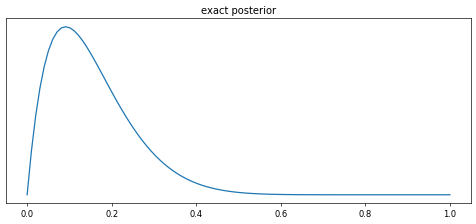

In [13]:
import math
import scipy.stats as stats

def posterior_grid(heads, tails, grid_points=100):
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points)
    likelihood = stats.binom.pmf(heads, heads +tails, grid)
    posterior = prior * likelihood
    posterior = posterior / posterior.sum()
    return grid, posterior

data = np.repeat([0,1], [10,1])
h = data.sum()
t = len(data) - h
x = np.linspace(0, 1, 100)
xs = x
dx_exact = xs[1] - xs[0]
post_exact = stats.beta.pdf(xs, a=h+1, b=t+1)
post_exact = post_exact / np.sum(post_exact)
plt.figure(figsize=(10, 4), dpi=60)
plt.plot(xs, post_exact)
plt.yticks([])
plt.title('exact posterior')
plt.show()

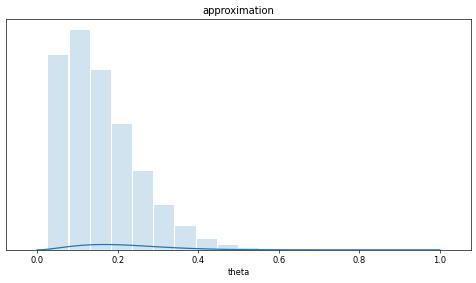

In [ ]:
n = 20
grid, posterior = posterior_grid(h, t, n)
dx_grid = grid[1] - grid[0]
sf = dx_grid / dx_exact

plt.figure(figsize=(10,5), dpi=60)
plt.bar(grid, posterior, width=1/n, alpha=.2)
plt.plot(xs, post_exact * xs)
plt.xlabel('theta')
plt.yticks([])
plt.title('approximation')
plt.show()

Output()

/usr/local/lib/python3.12/dist-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)


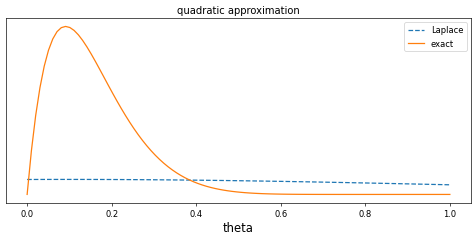

In [14]:
with pm.Model() as normal_approximation:
    theta = pm.Beta('theta', 1.0, 1.0)
    y = pm.Binomial('y', n=1, p=theta, observed=data)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[theta]))**0.5)[0]
    mu = mean_q['theta']

plt.figure(figsize=(10,4), dpi=60)
plt.plot(xs, stats.norm.pdf(xs, mu, std_q), linestyle='--', label='Laplace')
post_exact = stats.beta.pdf(xs, a=h+1, b=t+1)
plt.plot(xs, post_exact, label='exact')
plt.xlabel('theta', fontsize=14)
plt.yticks([])
plt.title('quadratic approximation')
plt.legend()
plt.show()

Output()

<Figure size 400x200 with 0 Axes>

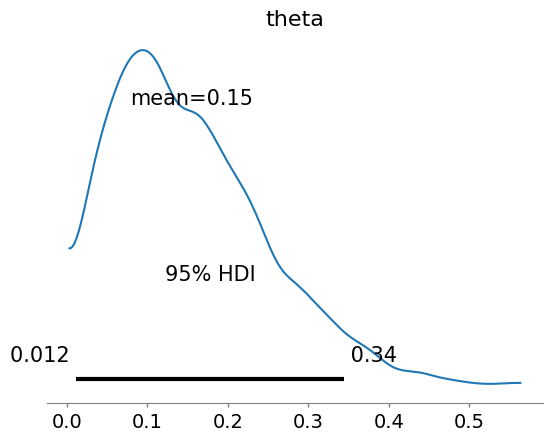

In [ ]:
with pm.Model() as hmc_model:
    theta = pm.Beta('theta', 1.0,1.0)
    y = pm.Binomial('y', n=1, p=theta, observed=data)
    trace = pm.sample(1000, random_seed=42, cores=1, chains=2)

plt.figure(figsize=(10,5), dpi=40)
# Correct way to plot posterior using arviz from InferenceData object
# 'ax' was not defined, so directly using az.plot_posterior
az.plot_posterior(trace, var_names=['theta'], hdi_prob=0.95)
plt.show()

<Figure size 600x360 with 0 Axes>

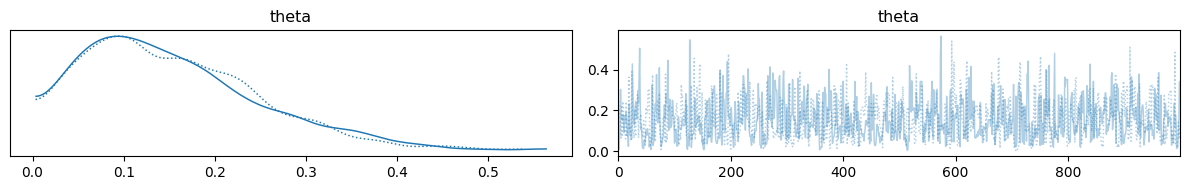

In [ ]:
plt.figure(figsize=(10, 6), dpi=60)
az.plot_trace(trace, var_names=['theta'])
plt.tight_layout()
plt.show()

Output()

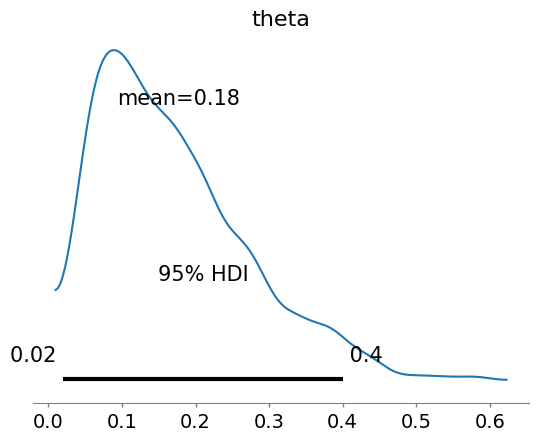

In [ ]:
with pm.Model() as mf_model:
    theta = pm.Beta('theta', 1.0, 1.0)
    y = pm.Binomial('y', n=1, p=theta, observed=data)
    mean_field = pm.fit(method='advi')
    trace_mf = mean_field.sample(1000)

thetas = trace_mf.posterior['theta']
axes = az.plot_posterior(thetas, hdi_prob=0.95)
plt.show()

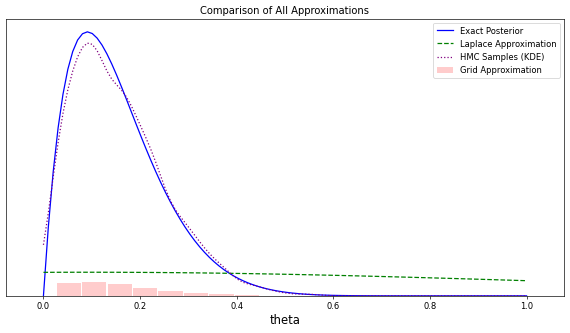

In [ ]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(12, 6), dpi=60)

# Exact posterior
plt.plot(xs, post_exact, label='Exact Posterior', color='blue')

# Grid approximation
plt.bar(grid, posterior, width=1/n, alpha=.2, color='red', label='Grid Approximation')

# Quadratic approximation (Laplace)
plt.plot(xs, stats.norm.pdf(xs, mu, std_q), linestyle='--', color='green', label='Laplace Approximation')

# HMC sampling results (KDE of samples)
hmc_samples = trace.posterior['theta'].values.flatten()
kde = gaussian_kde(hmc_samples)
plt.plot(xs, kde(xs), linestyle=':', color='purple', label='HMC Samples (KDE)')

plt.xlabel('theta', fontsize=14)
plt.yticks([])
plt.title('Comparison of All Approximations')
plt.legend()
plt.show()

Output()

Text(0.5, 1.0, 'Mean - Std - negative Elbo')

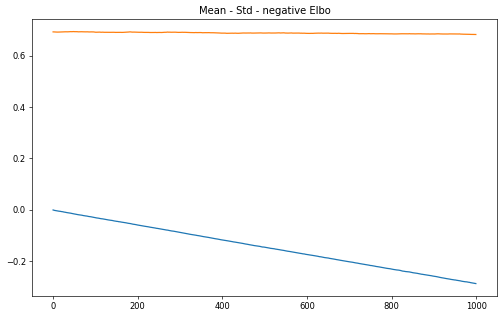

In [ ]:
with pm.Model() as mf_model:
    theta = pm.Beta('theta', 1.0, 1.0)
    y = pm.Binomial('y', n=1, p=theta, observed=data)
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(mean=advi.approx.mean.eval, std=advi.approx.std.eval)
    approx = advi.fit(n=1000, callbacks=[tracker])

trace_approx = approx.sample(1000)
theta = trace_approx.posterior['theta']

plt.figure(figsize=(10, 6), dpi=60)
plt.plot(tracker['mean'])
plt.plot(tracker['std'])
#plt.plot(advi.hist)
#sns.kdeplot(thetas)
plt.title('Mean - Std - negative Elbo' )

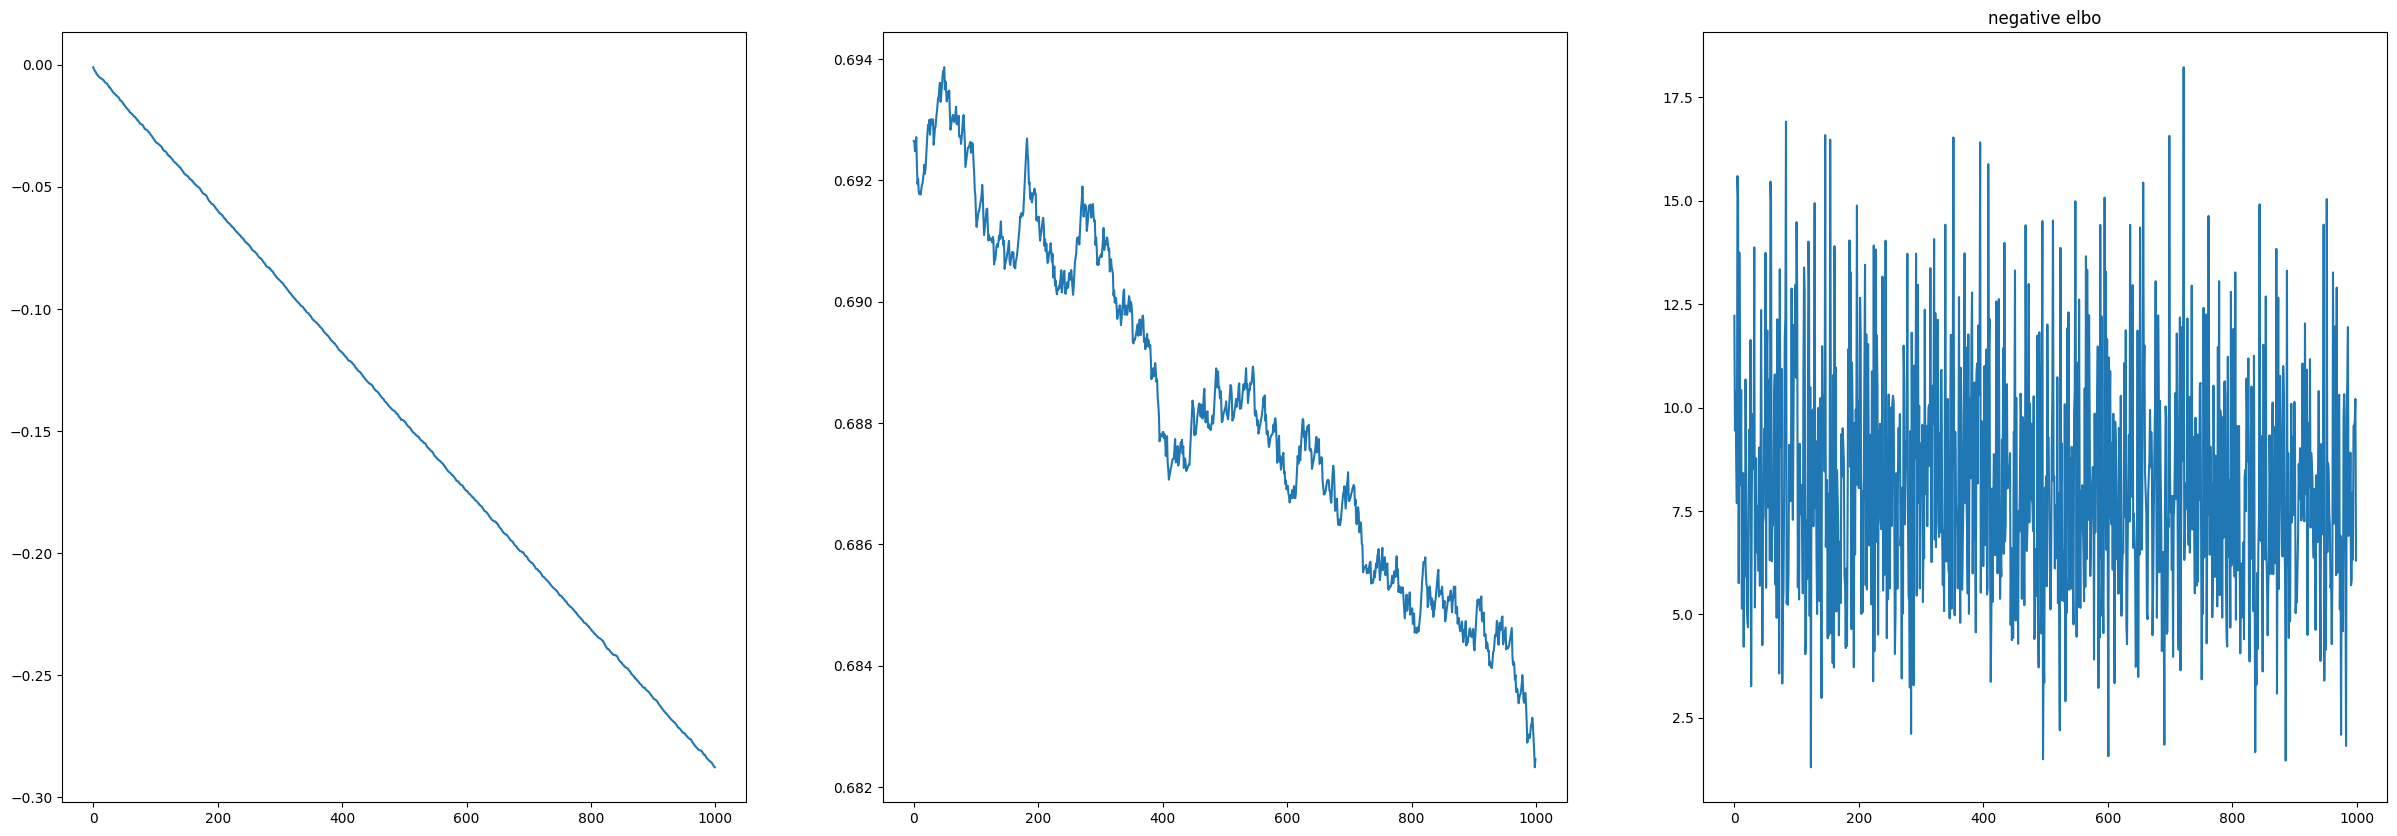

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
mu_ax = axs[0]
std_ax = axs[1]
elbo_ax = axs[2]
#kde_ax = axs[3]
mu_ax.plot(tracker['mean'])
std_ax.plot(tracker['std'])
elbo_ax.plot(advi.hist)
elbo_ax.set_title('negative elbo')
#kde_ax = sns.kdeplot(thetas)
#kde_ax.set_title('kde of posterior samples')
plt.show()

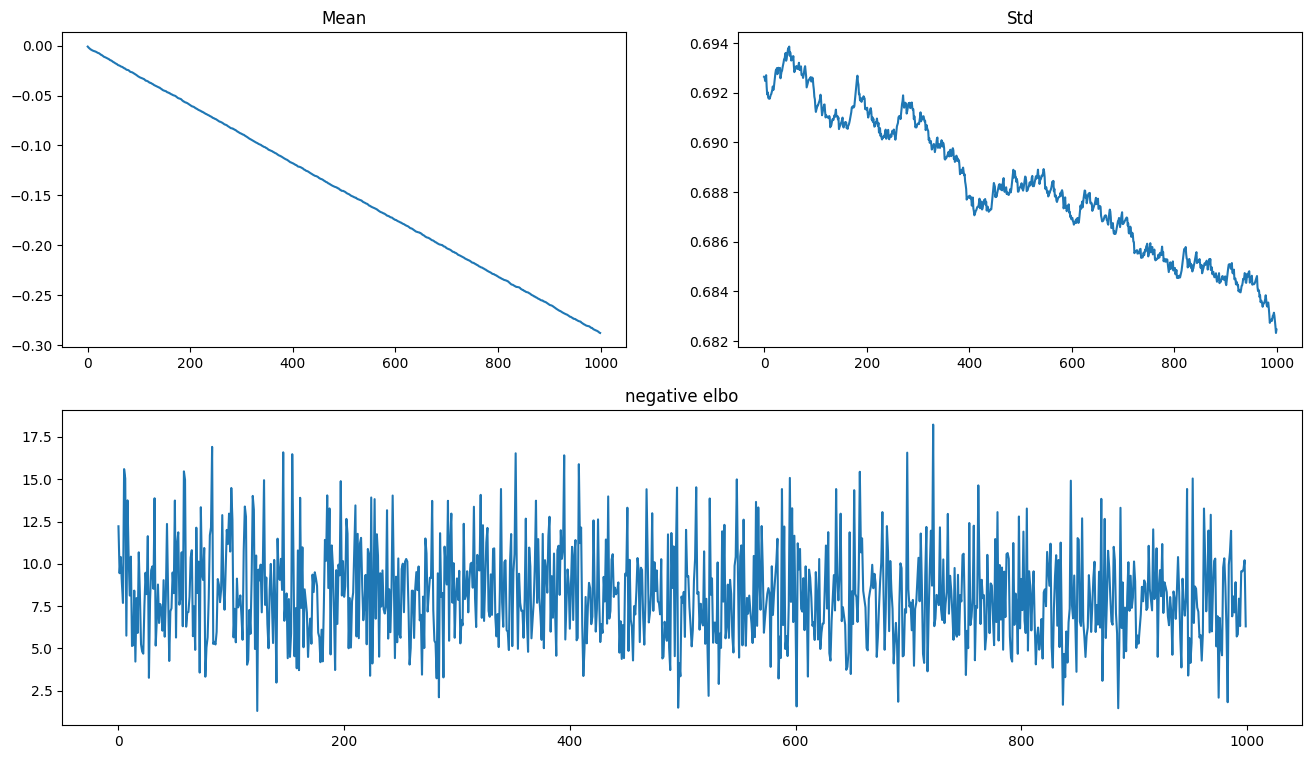

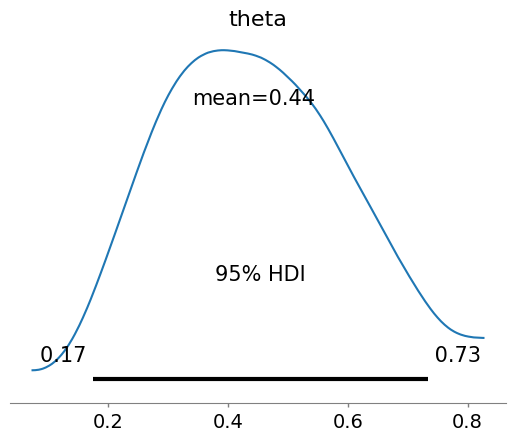

In [ ]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(2, 2, 1)
std_ax = fig.add_subplot(2, 2, 2)
hist_ax = fig.add_subplot(2, 1, 2)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean')
std_ax.plot(tracker['std'])
std_ax.set_title('Std')
hist_ax.plot(advi.hist)
hist_ax.set_title('negative elbo')

trace_approx = approx.sample(1000)
thetas = trace_approx.posterior['theta']
axes = az.plot_posterior(thetas, hdi_prob=0.95)
plt.show()